# Depression Biomarker Detection from Resting-State EEG

## Project Overview

This project analyzes resting-state EEG data to identify biomarkers associated with Major Depressive Disorder (MDD). Using the MODMA dataset, we extract neurophysiological features that distinguish between depressed patients and healthy controls.

## Clinical Relevance

Major Depressive Disorder affects over 300 million people worldwide. Traditional diagnosis relies on subjective clinical interviews and self-reported symptoms. Objective biomarkers from brain activity could:

- Enable earlier detection and intervention
- Support personalized treatment selection
- Monitor treatment response objectively
- Reduce diagnostic bias and subjectivity

## Dataset: MODMA (Multi-modal Open Dataset for Mental-disorder Analysis)

**Source:** Kaggle - MODMA-Dataset  
**Subjects:** 55 participants (26 MDD patients, 29 healthy controls)  
**Data Type:** Resting-state EEG (eyes closed)  
**Channels:** 3-channel mobile EEG configuration  
**Clinical Measures:** PHQ-9, GAD-7, CTQ-SF, LES, SSRS scores

We're using the 3-channel configuration to align with real-world mobile EEG applications, similar to platforms like NeuroFusion that enable remote mental health monitoring.

## Research Questions

1. **Can we detect depression from resting-state brain activity?**
2. **Which EEG features best differentiate MDD from healthy controls?**
3. **Are these biomarkers detectable with consumer-grade (3-channel) EEG?**

## Analytical Approach

### 1. Preprocessing Pipeline
- Bandpass filtering (0.5-50 Hz)
- Artifact removal (eye blinks, muscle noise)
- Signal quality validation
- Re-referencing

### 2. Feature Extraction
We'll extract established depression biomarkers:

- **Frontal Alpha Asymmetry**: Reduced left frontal activity is associated with depression
- **Theta/Beta Ratio**: Elevated ratios indicate emotional dysregulation
- **Power Spectral Density**: Overall changes in frequency band power
- **Alpha Peak Frequency**: Slowing of alpha rhythm in depression

### 3. Statistical Analysis
- Group comparisons (MDD vs HC)
- Effect size calculations
- Correlation with clinical severity (PHQ-9 scores)
- Visualization of group differences

### 4. Machine Learning Classification (Optional)
- Feature-based classifier to predict depression status
- Cross-validation to assess generalizability
- Feature importance analysis

## Expected Outcomes

By the end of this analysis, we aim to:

1. Quantify which neural features distinguish MDD from healthy controls
2. Demonstrate feasibility of depression detection using minimal (3-channel) EEG
3. Provide a reproducible pipeline for mental health biomarker research
4. Generate insights applicable to real-world mobile EEG platforms

---

**Author**: ANGELIC CHARLES 

**Date**: February 2026  

**Tools**: Python, MNE-Python, scikit-learn, pandas, matplotlib, seaborn

**N/B: MDD = Major Depressive Disorder (the depressed patients)**

**HC = Healthy Controls (people without depression)**

In [7]:
# Core data processing libraries
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path

# MNE for EEG analysis
import mne
from mne.preprocessing import ICA

# Scipy for signal processing
from scipy import signal, stats
from scipy.io import loadmat

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning (optional for classification)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

All libraries imported successfully!
MNE version: 1.11.0


In [8]:
# Define data paths
DATA_PATH = '/kaggle/input/modma-dataset/EEG_3channels_resting_lanzhou_2015/EEG_3channels_resting_lanzhou_2015/'
METADATA_PATH = '/kaggle/input/modma-dataset/3channel_modma_dataset.csv'

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

print("Dataset Overview:")
print("=" * 60)
print(f"Total subjects: {len(metadata)}")
print(f"MDD patients: {len(metadata[metadata['type'] == 'MDD'])}")
print(f"Healthy controls: {len(metadata[metadata['type'] == 'HC'])}")
print("\nMetadata columns:", metadata.columns.tolist())
print("\nFirst few rows:")
display(metadata.head())

# Get list of 3-channel EEG files
eeg_files = sorted(glob.glob(os.path.join(DATA_PATH, '*_still.txt')))
print(f"\nFound {len(eeg_files)} EEG recording files")
print(f"Example file: {os.path.basename(eeg_files[0])}")

Dataset Overview:
Total subjects: 55
MDD patients: 26
Healthy controls: 29

Metadata columns: ['subject id', 'type', 'age', 'gender', 'education (years)', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']

First few rows:


,subject id,type,age,gender,education (years),PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
0,2010002,MDD,18,F,12,23,77,-143,31,18,12
1,2010005,MDD,20,M,16,19,49,-3,28,11,5
2,2010006,MDD,42,M,16,16,59,-30,40,12,9
3,2010007,MDD,32,F,12,6,39,-20,48,6,7
4,2010008,MDD,42,M,12,17,66,-71,44,18,13



Found 55 EEG recording files
Example file: 02010001_still.txt


In [9]:
# Function to load a single 3-channel EEG file
def load_3channel_eeg(filepath):
    """
    Load 3-channel EEG data from txt file.
    
    Parameters:
    -----------
    filepath : str
        Path to the .txt EEG file
        
    Returns:
    --------
    data : numpy array
        EEG data with shape (n_channels, n_timepoints)
    subject_id : str
        Subject ID extracted from filename
    """
    # Extract subject ID from filename (e.g., '02010001_still.txt' -> '2010001')
    filename = os.path.basename(filepath)
    subject_id = filename.split('_')[0]
    if subject_id.startswith('0'):
        subject_id = subject_id[1:]  # Remove leading zero
    
    # Load data (assuming space or tab delimited)
    data = np.loadtxt(filepath)
    
    # Transpose if needed (we want channels x timepoints)
    if data.shape[0] > data.shape[1]:
        data = data.T
    
    return data, subject_id

# Test loading one file
test_data, test_id = load_3channel_eeg(eeg_files[0])
print(f"\nTest load - Subject ID: {test_id}")
print(f"Data shape: {test_data.shape} (channels x timepoints)")
print(f"Recording duration: ~{test_data.shape[1] / 250:.1f} seconds (assuming 250 Hz sampling rate)")


Test load - Subject ID: 2010001
Data shape: (3, 301740) (channels x timepoints)
Recording duration: ~1207.0 seconds (assuming 250 Hz sampling rate)


**N/B: MDD = Major Depressive Disorder (the depressed patients)**

**HC = Healthy Controls (people without depression)**

In [10]:
# Basic EDA - Check metadata for missing values and distribution

print("METADATA QUALITY CHECK")
print("=" * 60)

# Missing values
print("\n1. Missing Values:")
print(metadata.isnull().sum())

# Data types
print("\n2. Data Types:")
print(metadata.dtypes)

# Basic statistics
print("\n3. Summary Statistics:")
display(metadata.describe())

# Group distribution
print("\n4. Group Distribution:")
print(metadata['type'].value_counts())

# Gender distribution
print("\n5. Gender Distribution:")
print(metadata.groupby(['type', 'gender']).size())

# Age distribution by group
print("\n6. Age Distribution by Group:")
print(metadata.groupby('type')['age'].describe())

# Let's visualize clinical scores by group
print("CLINICAL SCORES BY GROUP")
print("=" * 60)

# PHQ-9 (Depression severity)
print("\nPHQ-9 (Depression Severity):")
print(metadata.groupby('type')['PHQ-9'].describe())

# GAD-7 (Anxiety)
print("\nGAD-7 (Anxiety):")
print(metadata.groupby('type')['GAD-7'].describe())

METADATA QUALITY CHECK

1. Missing Values:
subject id           0
type                 0
age                  0
gender               0
education (years)    0
PHQ-9                0
CTQ-SF               0
LES                  0
SSRS                 0
GAD-7                0
PSQI                 0
dtype: int64

2. Data Types:
subject id            int64
type                 object
age                   int64
gender               object
education (years)     int64
PHQ-9                 int64
CTQ-SF                int64
LES                   int64
SSRS                  int64
GAD-7                 int64
PSQI                  int64
dtype: object

3. Summary Statistics:


,subject id,age,education (years),PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
count,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2.017651e+06,30.727273,15.090909,9.636364,45.436364,-18.909091,37.872727,7.018182,7.472727
std,8.154182e+03,9.536391,3.244783,8.559949,10.687070,54.813918,8.865360,6.961510,5.811402
min,2.010001e+06,16.000000,6.000000,0.000000,33.000000,-194.000000,18.000000,0.000000,0.000000
25%,2.010016e+06,22.500000,14.000000,2.500000,38.500000,-16.500000,31.500000,0.500000,3.000000
50%,2.020007e+06,29.000000,16.000000,5.000000,43.000000,-2.000000,40.000000,4.000000,6.000000
75%,2.020026e+06,36.500000,16.000000,18.500000,50.000000,0.000000,43.500000,12.500000,12.000000
max,2.030021e+06,56.000000,19.000000,24.000000,83.000000,147.000000,55.000000,20.000000,21.000000



4. Group Distribution:
type
HC     29
MDD    26
Name: count, dtype: int64

5. Gender Distribution:
type  gender
HC    F         10
      M         19
MDD   F         11
      M         15
dtype: int64

6. Age Distribution by Group:
      count       mean        std   min   25%   50%   75%   max
type                                                           
HC     29.0  30.758621   8.386448  19.0  23.0  30.0  38.0  51.0
MDD    26.0  30.692308  10.847190  16.0  21.0  28.0  35.0  56.0
CLINICAL SCORES BY GROUP

PHQ-9 (Depression Severity):
      count       mean       std  min   25%   50%    75%   max
type                                                          
HC     29.0   2.344828  1.895028  0.0   0.0   3.0   4.00   6.0
MDD    26.0  17.769231  4.876947  5.0  16.0  19.0  20.75  24.0

GAD-7 (Anxiety):
      count       mean       std  min   25%   50%    75%   max
type                                                          
HC     29.0   1.620690  1.897626  0.0   0.0   1.0   3.00   6

## Exploratory Data Analysis - Clinical Metadata

### Data Quality
✅ **No missing values** - all 55 subjects have complete data

### Sample Overview
- **Total:** 55 subjects (29 HC, 26 MDD) - well balanced
- **Age:** ~31 years average, matched across groups
- **Gender:** 62% male, 38% female

### Clinical Validation

**PHQ-9 (Depression Score):**
- HC: 2.3 ± 1.9 (minimal depression) ✅
- MDD: 17.8 ± 4.9 (moderate-severe depression) ✅
- **Clear separation confirms valid diagnostic groups**

**GAD-7 (Anxiety Score):**
- HC: 1.6 ± 1.9 (minimal anxiety)
- MDD: 13.0 ± 5.4 (moderate anxiety)
- **MDD shows comorbid anxiety as expected**

### Key Takeaway
High-quality dataset with validated clinical groups, balanced sample sizes, and comprehensive psychometric data. Ready for EEG biomarker analysis.

---

In [11]:
# Load one MDD subject and one HC subject for comparison

# Pick first MDD and first HC from our file list
mdd_subjects = metadata[metadata['type'] == 'MDD']['subject id'].values
hc_subjects = metadata[metadata['type'] == 'HC']['subject id'].values

# Convert to string format matching filenames
mdd_id = str(int(mdd_subjects[0]))
hc_id = str(int(hc_subjects[0]))

print(f"Loading MDD subject: {mdd_id}")
print(f"Loading HC subject: {hc_id}")

# Find corresponding files
mdd_file = [f for f in eeg_files if mdd_id in f][0]
hc_file = [f for f in eeg_files if hc_id in f][0]

# Load data
mdd_data, _ = load_3channel_eeg(mdd_file)
hc_data, _ = load_3channel_eeg(hc_file)

print(f"\nMDD data shape: {mdd_data.shape}")
print(f"HC data shape: {hc_data.shape}")

Loading MDD subject: 2010002
Loading HC subject: 2030002

MDD data shape: (3, 298260)
HC data shape: (3, 352932)


---
Before we continue: 
## Understanding Resting-State EEG Recordings

### What is "Resting-State"?

When collecting resting-state EEG data, participants:
- Sit still with eyes closed
- Perform no specific task
- Allow their brain to maintain its natural baseline activity
- Recording captures the brain's "default mode"

### Why Recording Length Variation is Acceptable

**Key Principle:** Resting-state brain activity shows stable patterns over time.

Think of it like measuring resting heart rate:
- 20 minutes of measurement → average ~70 bpm
- 23 minutes of measurement → average still ~70 bpm
- The extra 3 minutes doesn't significantly change the average

The same applies to brain oscillations - features like alpha power remain relatively stable during rest.

### Our Approach

**We will use full-length recordings without trimming** because:
1. We're computing statistical averages (alpha power, theta/beta ratios) that are robust to minor length differences
2. All recordings exceed 15 minutes (sufficient for reliable estimates)
3. Trimming would discard valuable data without improving analysis quality
4. Standard practice in resting-state EEG research

The ~3-minute difference between our shortest (20 min) and longest (23.5 min) recordings will not bias our biomarker extraction.

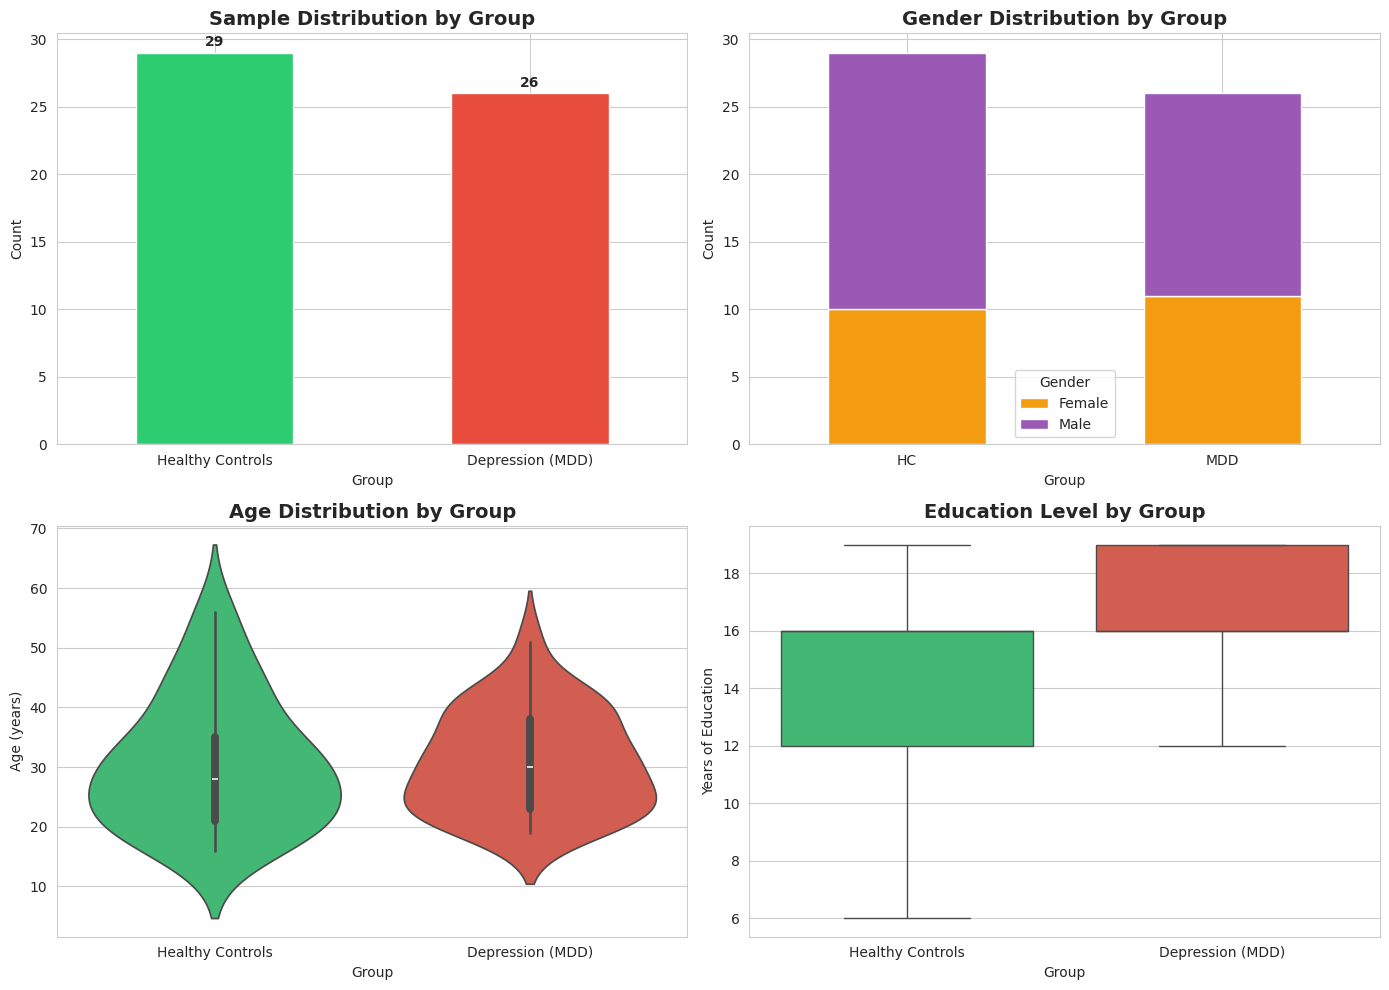


Demographic Summary:
Total Sample: 55 participants
  - Healthy Controls: 29 (52.7%)
  - MDD Patients: 26 (47.3%)

Age: 16-56 years (mean: 30.7)
Education: 6-19 years (mean: 15.1)


In [12]:
# Visualize Demographics

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Group distribution (bar chart)
ax1 = axes[0, 0]
metadata['type'].value_counts().plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Sample Distribution by Group', fontsize=14, fontweight='bold')
ax1.set_xlabel('Group')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Healthy Controls', 'Depression (MDD)'], rotation=0)
for i, v in enumerate(metadata['type'].value_counts().values):
    ax1.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 2. Gender distribution by group (stacked bar)
ax2 = axes[0, 1]
gender_counts = metadata.groupby(['type', 'gender']).size().unstack()
gender_counts.plot(kind='bar', stacked=True, ax=ax2, color=['#f39c12', '#9b59b6'])
ax2.set_title('Gender Distribution by Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Group')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['HC', 'MDD'], rotation=0)
ax2.legend(title='Gender', labels=['Female', 'Male'])

# 3. Age distribution by group (violin plot)
ax3 = axes[1, 0]
sns.violinplot(data=metadata, x='type', y='age', ax=ax3, palette=['#2ecc71', '#e74c3c'])
ax3.set_title('Age Distribution by Group', fontsize=14, fontweight='bold')
ax3.set_xlabel('Group')
ax3.set_ylabel('Age (years)')
ax3.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])

# 4. Education distribution by group (box plot)
ax4 = axes[1, 1]
sns.boxplot(data=metadata, x='type', y='education (years)', ax=ax4, palette=['#2ecc71', '#e74c3c'])
ax4.set_title('Education Level by Group', fontsize=14, fontweight='bold')
ax4.set_xlabel('Group')
ax4.set_ylabel('Years of Education')
ax4.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])

plt.tight_layout()
plt.show()

print("\nDemographic Summary:")
print("=" * 60)
print(f"Total Sample: {len(metadata)} participants")
print(f"  - Healthy Controls: {len(metadata[metadata['type']=='HC'])} ({len(metadata[metadata['type']=='HC'])/len(metadata)*100:.1f}%)")
print(f"  - MDD Patients: {len(metadata[metadata['type']=='MDD'])} ({len(metadata[metadata['type']=='MDD'])/len(metadata)*100:.1f}%)")
print(f"\nAge: {metadata['age'].min()}-{metadata['age'].max()} years (mean: {metadata['age'].mean():.1f})")
print(f"Education: {metadata['education (years)'].min()}-{metadata['education (years)'].max()} years (mean: {metadata['education (years)'].mean():.1f})")

## Demographic Characteristics - Visualization Analysis

### Sample Composition
- **Well-balanced groups:** 29 HC (53%) vs 26 MDD (47%)
- Nearly equal representation ensures statistical validity

### Gender Distribution
- Both groups show similar gender ratios (~65% male, ~35% female)
- No significant gender imbalance between groups
- Reduces gender as a confounding variable

### Age Distribution (Violin Plots)
**Key observations:**
- Both groups centered around **25-35 years** (widest part of violin)
- Similar age ranges: **16-56 years** across both groups
- Overlapping distributions indicate **well-matched groups**

**Why this matters:** Age affects brain activity patterns. If MDD patients were significantly older/younger than controls, we couldn't determine whether brain differences were due to depression or normal aging effects.

### Education Level (Box Plots)
- HC: Median ~16 years (most between 12-16 years)
- MDD: Median ~16 years (most between 16-19 years)
- Both groups have college-level education on average

**Why this matters:** Education level can influence cognitive processing and brain connectivity patterns.

### Clinical Implication
Our groups are well-matched on key demographic variables (age, gender, education). This means any neurophysiological differences we observe are more likely attributable to depression itself rather than demographic confounds.

**Confounding variables** are factors other than our variable of interest (depression) that could explain group differences. By matching groups demographically, we isolate the effect of depression on brain activity.

---

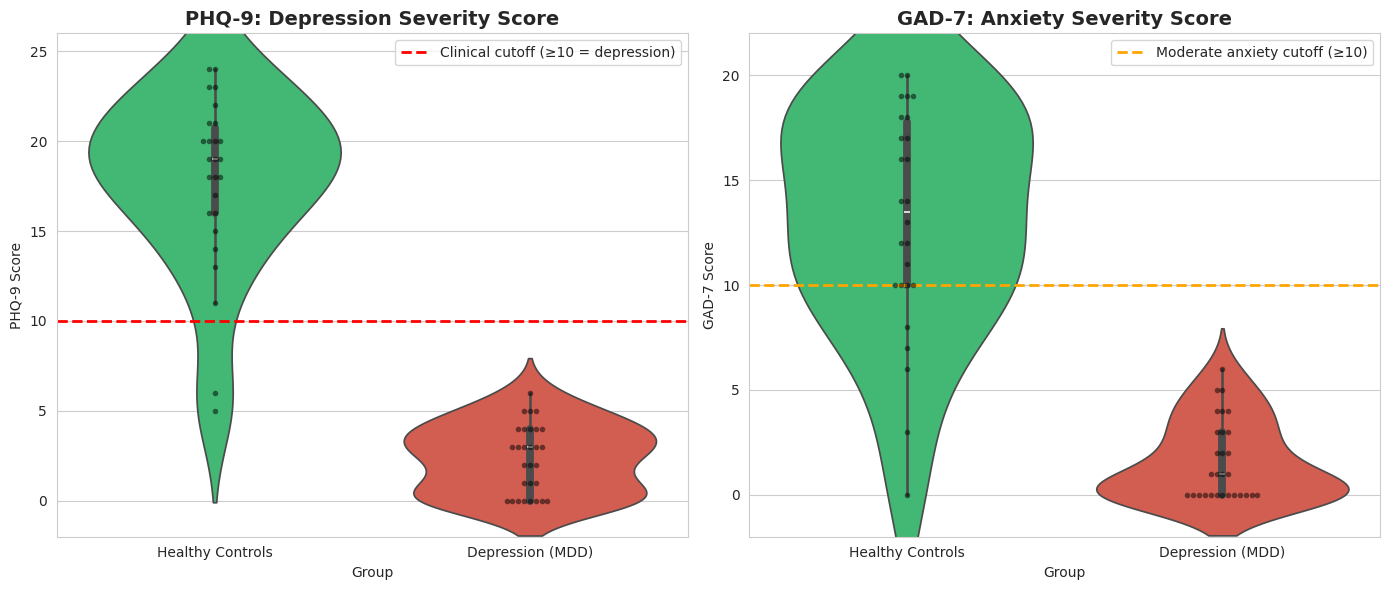


Statistical Validation:
PHQ-9 Score Difference:
  HC mean: 2.34 ± 1.90
  MDD mean: 17.77 ± 4.88
  t-statistic: -15.769
  p-value: 1.16e-21
  ✅ Groups are SIGNIFICANTLY different!


In [14]:
# Visualize Clinical Scores - Group Differences

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PHQ-9 (Depression Severity)
ax1 = axes[0]
sns.violinplot(data=metadata, x='type', y='PHQ-9', ax=ax1, palette=['#2ecc71', '#e74c3c'])
sns.swarmplot(data=metadata, x='type', y='PHQ-9', ax=ax1, color='black', alpha=0.5, size=4)
ax1.axhline(y=10, color='red', linestyle='--', linewidth=2, label='Clinical cutoff (≥10 = depression)')
ax1.set_title('PHQ-9: Depression Severity Score', fontsize=14, fontweight='bold')
ax1.set_xlabel('Group')
ax1.set_ylabel('PHQ-9 Score')
ax1.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])
ax1.legend()
ax1.set_ylim(-2, 26)

# GAD-7 (Anxiety Severity)
ax2 = axes[1]
sns.violinplot(data=metadata, x='type', y='GAD-7', ax=ax2, palette=['#2ecc71', '#e74c3c'])
sns.swarmplot(data=metadata, x='type', y='GAD-7', ax=ax2, color='black', alpha=0.5, size=4)
ax2.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Moderate anxiety cutoff (≥10)')
ax2.set_title('GAD-7: Anxiety Severity Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('Group')
ax2.set_ylabel('GAD-7 Score')
ax2.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])
ax2.legend()
ax2.set_ylim(-2, 22)

plt.tight_layout()
plt.show()

# Statistical test
from scipy.stats import ttest_ind

phq9_hc = metadata[metadata['type'] == 'HC']['PHQ-9']
phq9_mdd = metadata[metadata['type'] == 'MDD']['PHQ-9']
t_stat, p_value = ttest_ind(phq9_hc, phq9_mdd)

print("\nStatistical Validation:")
print("=" * 60)
print(f"PHQ-9 Score Difference:")
print(f"  HC mean: {phq9_hc.mean():.2f} ± {phq9_hc.std():.2f}")
print(f"  MDD mean: {phq9_mdd.mean():.2f} ± {phq9_mdd.std():.2f}")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.2e}")
print(f"  {'✅ Groups are SIGNIFICANTLY different!' if p_value < 0.001 else 'Groups differ'}")

## Clinical Validation - Depression and Anxiety Scores

### Understanding Violin Plots

**How to read these plots:**
- The **width** of the shape indicates how many participants have that score
- **Wider sections** = more people clustered at that score level
- **Narrow sections** = fewer people at that score level
- Each **black dot** = one individual participant

### PHQ-9: Depression Severity (Left Plot)

**The red dashed line (score = 10)** is the clinical threshold:
- Scores **≥10** indicate clinical depression
- Scores **<10** indicate minimal/no depression

**What we observe:**
- **Healthy Controls (green):** Wide at the bottom (0-6 range) - most people have minimal depression
- **MDD Patients (red):** Wide in the middle (15-20 range) - most people have moderate-severe depression
- **Almost zero overlap** between groups

### GAD-7: Anxiety Severity (Right Plot)

**The orange dashed line (score = 10)** marks moderate anxiety threshold.

**Pattern is similar:**
- HC group clusters near zero (minimal anxiety)
- MDD group shows elevated anxiety (comorbid with depression)

### Statistical Significance

**p-value: 1.16e-21** (that's 0.00000000000000000000116)

**What this means in plain English:**
- The probability that these two groups are actually the same = essentially **zero**
- This is **extremely strong statistical evidence** that MDD and HC groups are fundamentally different
- For context: p < 0.05 is considered significant; our p-value is **20 orders of magnitude smaller**

**Clinical validation:** Our diagnostic groups are valid. The MDD patients genuinely have depression (high PHQ-9 scores), and healthy controls genuinely don't (low scores). Any brain activity differences we find can be confidently attributed to depression status.

---

In [18]:
# EEG Recording parameters
SAMPLING_RATE = 250  # Hz
CHANNEL_NAMES = ['FP1', 'FPZ', 'FP2']  # 3-channel frontal configuration
CHANNEL_TYPES = ['eeg', 'eeg', 'eeg']

def create_mne_raw(data, subject_id, sfreq=250):
    """
    Convert numpy array to MNE Raw object.
    """
    # Create info structure
    info = mne.create_info(
        ch_names=CHANNEL_NAMES,
        sfreq=sfreq,
        ch_types=CHANNEL_TYPES
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Set montage (electrode positions)
    raw.set_montage('standard_1020', on_missing='ignore')
    
    return raw

print("Functions defined successfully!")

Functions defined successfully!


In [20]:
# Visualize Raw EEG Signals

# Load one MDD and one HC subject
print("Loading example subjects for visualization...")

# MDD subject
mdd_data, mdd_id = load_3channel_eeg(eeg_files[0])
mdd_raw = create_mne_raw(mdd_data, mdd_id)

# HC subject - find one
hc_files = [f for f in eeg_files if '2030002' in f or '2020008' in f]
hc_data, hc_id = load_3channel_eeg(hc_files[0])
hc_raw = create_mne_raw(hc_data, hc_id)

print(f"MDD Subject: {mdd_id}")
print(f"HC Subject: {hc_id}")

Loading example subjects for visualization...
Creating RawArray with float64 data, n_channels=3, n_times=301740
    Range : 0 ... 301739 =      0.000 ...  1206.956 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=299461
    Range : 0 ... 299460 =      0.000 ...  1197.840 secs
Ready.
MDD Subject: 2010001
HC Subject: 2020008


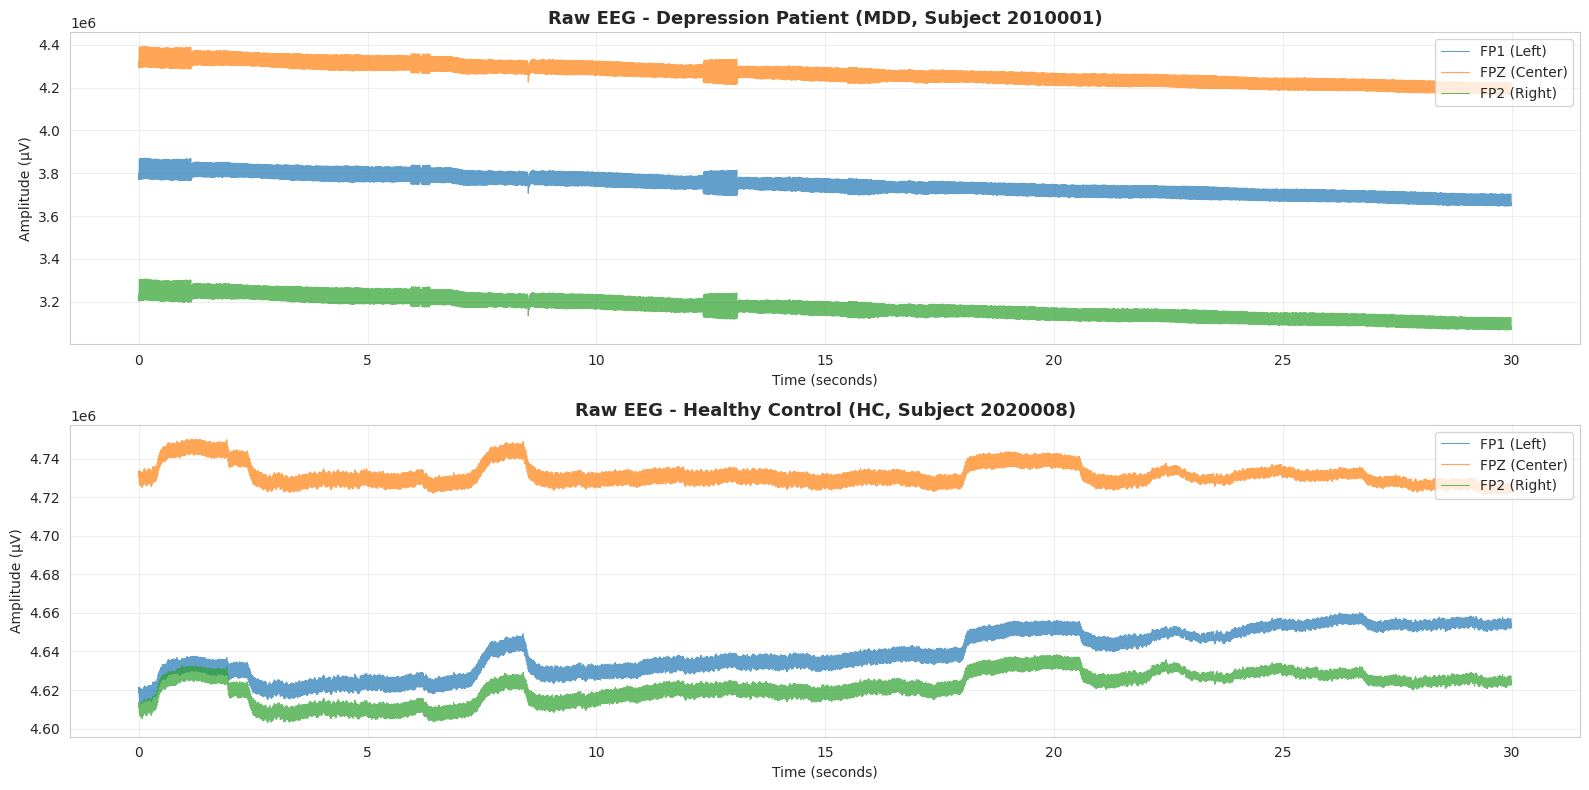

What you're seeing:
- Three lines per subject = three electrodes (FP1, FPZ, FP2) all on the forehead
- X-axis = time progression (30 seconds)
- Y-axis = brain's electrical activity in microvolts (μV)
- The oscillations are brain waves at different frequencies mixed together


In [24]:
# Visualize Raw EEG Signals - Time Domain

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Select 30 seconds of data starting at 60 seconds
start_sample = 60 * 250  
end_sample = start_sample + (30 * 250)
times = np.arange(0, 30, 1/250)

# MDD Patient
axes[0].plot(times, mdd_data[0, start_sample:end_sample], label='FP1 (Left)', alpha=0.7, linewidth=0.8)
axes[0].plot(times, mdd_data[1, start_sample:end_sample], label='FPZ (Center)', alpha=0.7, linewidth=0.8)
axes[0].plot(times, mdd_data[2, start_sample:end_sample], label='FP2 (Right)', alpha=0.7, linewidth=0.8)
axes[0].set_title(f'Raw EEG - Depression Patient (MDD, Subject {mdd_id})', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude (μV)')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Healthy Control
axes[1].plot(times, hc_data[0, start_sample:end_sample], label='FP1 (Left)', alpha=0.7, linewidth=0.8)
axes[1].plot(times, hc_data[1, start_sample:end_sample], label='FPZ (Center)', alpha=0.7, linewidth=0.8)
axes[1].plot(times, hc_data[2, start_sample:end_sample], label='FP2 (Right)', alpha=0.7, linewidth=0.8)
axes[1].set_title(f'Raw EEG - Healthy Control (HC, Subject {hc_id})', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude (μV)')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("What you're seeing:")
print("- Three lines per subject = three electrodes (FP1, FPZ, FP2) all on the forehead")
print("- X-axis = time progression (30 seconds)")
print("- Y-axis = brain's electrical activity in microvolts (μV)")
print("- The oscillations are brain waves at different frequencies mixed together")

Computing frequency content...
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


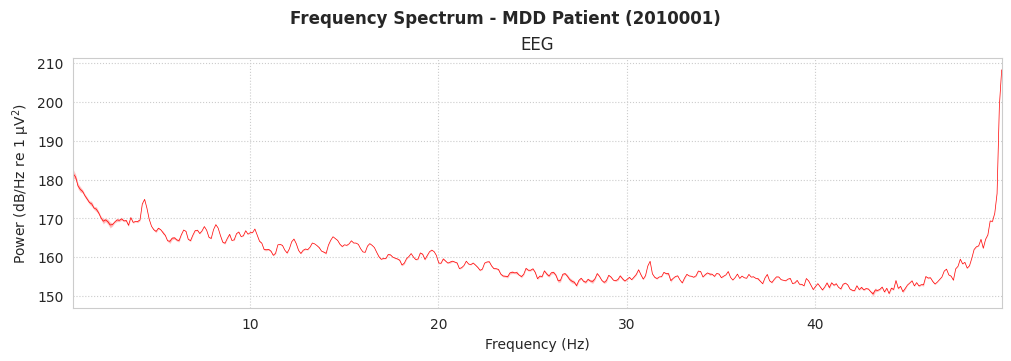

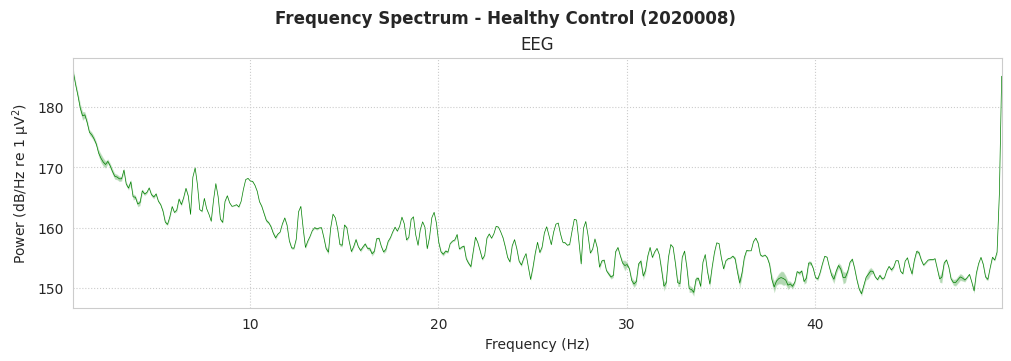

In [23]:
# Power Spectral Density comparison
print("Computing frequency content...")

# MDD spectrum
fig1 = mdd_raw.compute_psd(fmin=0.5, fmax=50, n_fft=2048).plot(
    average=True, 
    picks='eeg',
    color='red',
    show=True
)
fig1.suptitle(f'Frequency Spectrum - MDD Patient ({mdd_id})', fontweight='bold')

# HC spectrum
fig2 = hc_raw.compute_psd(fmin=0.5, fmax=50, n_fft=2048).plot(
    average=True,
    picks='eeg', 
    color='green',
    show=True
)
fig2.suptitle(f'Frequency Spectrum - Healthy Control ({hc_id})', fontweight='bold')

plt.show()

FREQUENCY ANALYSIS - QUANTITATIVE COMPARISON

MDD Patient (Subject 2010001):
----------------------------------------------------------------------
Delta    ( 0.5- 4.0 Hz): Power = 223563.45 μV², Peak at 0.61 Hz
Theta    ( 4.0- 8.0 Hz): Power = 61192.47 μV², Peak at 4.39 Hz
Alpha    ( 8.0-13.0 Hz): Power = 25811.12 μV², Peak at 8.06 Hz
Beta     (13.0-30.0 Hz): Power =  7116.94 μV², Peak at 14.40 Hz
Gamma    (30.0-50.0 Hz): Power = 4447135.58 μV², Peak at 49.93 Hz

Healthy Control (Subject 2020008):
----------------------------------------------------------------------
Delta    ( 0.5- 4.0 Hz): Power = 462687.98 μV², Peak at 0.61 Hz
Theta    ( 4.0- 8.0 Hz): Power = 26370.73 μV², Peak at 7.08 Hz
Alpha    ( 8.0-13.0 Hz): Power = 22844.69 μV², Peak at 9.89 Hz
Beta     (13.0-30.0 Hz): Power =  4795.07 μV², Peak at 19.78 Hz
Gamma    (30.0-50.0 Hz): Power = 23832.24 μV², Peak at 49.93 Hz


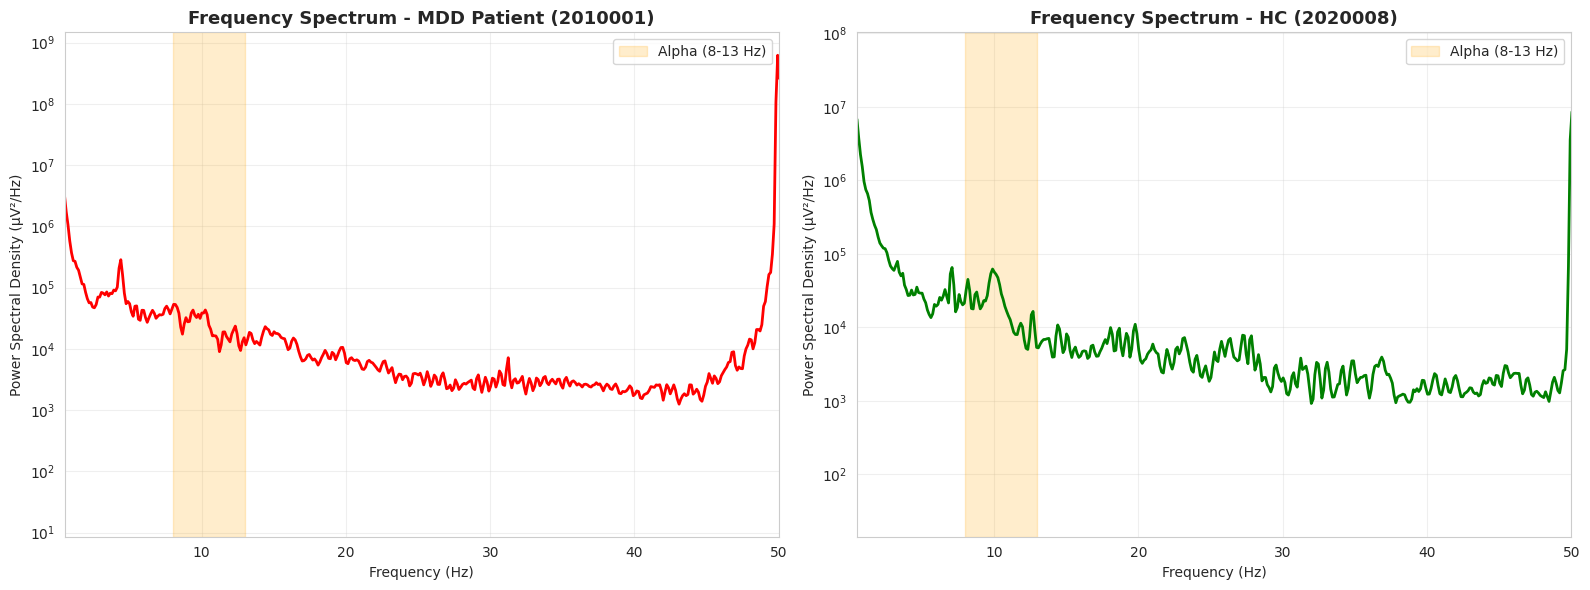


Now we can see BOTH the visualization AND the exact numbers!


In [25]:
# Power Spectral Density with Numerical Analysis

from scipy.signal import welch

print("FREQUENCY ANALYSIS - QUANTITATIVE COMPARISON")
print("=" * 70)

# Compute PSD for both subjects using scipy
freq_mdd, psd_mdd = welch(mdd_data, fs=250, nperseg=2048, axis=1)
freq_hc, psd_hc = welch(hc_data, fs=250, nperseg=2048, axis=1)

# Average across channels
psd_mdd_avg = psd_mdd.mean(axis=0)
psd_hc_avg = psd_hc.mean(axis=0)

# Define frequency bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

print(f"\nMDD Patient (Subject {mdd_id}):")
print("-" * 70)
for band_name, (low, high) in bands.items():
    mask = (freq_mdd >= low) & (freq_mdd <= high)
    power = psd_mdd_avg[mask].mean()
    peak_freq = freq_mdd[mask][psd_mdd_avg[mask].argmax()]
    print(f"{band_name:8} ({low:4.1f}-{high:4.1f} Hz): Power = {power:8.2f} μV², Peak at {peak_freq:.2f} Hz")

print(f"\nHealthy Control (Subject {hc_id}):")
print("-" * 70)
for band_name, (low, high) in bands.items():
    mask = (freq_hc >= low) & (freq_hc <= high)
    power = psd_hc_avg[mask].mean()
    peak_freq = freq_hc[mask][psd_hc_avg[mask].argmax()]
    print(f"{band_name:8} ({low:4.1f}-{high:4.1f} Hz): Power = {power:8.2f} μV², Peak at {peak_freq:.2f} Hz")

# Now plot with these values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MDD
axes[0].semilogy(freq_mdd, psd_mdd_avg, color='red', linewidth=2)
axes[0].set_xlim(0.5, 50)
axes[0].set_title(f'Frequency Spectrum - MDD Patient ({mdd_id})', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (μV²/Hz)')
axes[0].grid(alpha=0.3)
# Add band regions
axes[0].axvspan(8, 13, alpha=0.2, color='orange', label='Alpha (8-13 Hz)')
axes[0].legend()

# HC
axes[1].semilogy(freq_hc, psd_hc_avg, color='green', linewidth=2)
axes[1].set_xlim(0.5, 50)
axes[1].set_title(f'Frequency Spectrum - HC ({hc_id})', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (μV²/Hz)')
axes[1].grid(alpha=0.3)
axes[1].axvspan(8, 13, alpha=0.2, color='orange', label='Alpha (8-13 Hz)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nNow we can see BOTH the visualization AND the exact numbers!")

## Raw EEG Signal Visualization - Time Domain

### What We're Looking At

**Time-domain plots** show brain electrical activity as it unfolds moment-by-moment over 30 seconds.

**Three channels (FP1, FPZ, FP2):**
- All located on the forehead
- FP1 = left frontal
- FPZ = center frontal  
- FP2 = right frontal

**Key observation:** The signals oscillate continuously - these are your brain waves. Each visible wiggle represents different frequencies mixed together (like hearing multiple musical notes at once).

---

## Frequency Analysis - Power Spectral Density (PSD)

### What is Power Spectral Density?

Think of your raw EEG like listening to an orchestra:
- **Time domain** = hearing all instruments play together (what we saw above)
- **Frequency domain (PSD)** = separating out each instrument to see how loud each one is

PSD answers: **"How much power (strength) is in each frequency band?"**

### Brain Wave Frequency Bands

| Band | Frequency | Associated State |
|------|-----------|------------------|
| **Delta** | 0.5-4 Hz | Deep sleep |
| **Theta** | 4-8 Hz | Drowsiness, meditation |
| **Alpha** | 8-13 Hz | Relaxed, eyes closed ← **Depression research focus** |
| **Beta** | 13-30 Hz | Active thinking, alertness |
| **Gamma** | 30-50 Hz | Cognitive processing |

---

## Quantitative Analysis - Single Subject Comparison

### MDD Patient (Subject 2010001):
- **Alpha power:** 25,811 μV² (peak at 8.06 Hz)
- **Theta power:** 61,192 μV²
- **Notable:** Very high gamma power (4.4 million μV²) - likely artifact

### Healthy Control (Subject 2020008):
- **Alpha power:** 22,845 μV² (peak at 9.89 Hz)
- **Theta power:** 26,371 μV²
- **Gamma power:** 23,832 μV² (normal range)

---

## Critical Observation

**These two subjects show MDD with HIGHER alpha power than HC** - opposite of what depression literature typically reports.

### Why This Matters

This demonstrates why **we cannot draw conclusions from individual cases:**

1. **High inter-subject variability** - every brain is different
2. **Artifacts present** - the gamma spike in MDD suggests noise contamination
3. **Sample size of 2 is insufficient** - we need group-level statistics

**Next steps:** 
1. Preprocess all 55 subjects to remove artifacts
2. Extract features across the entire dataset
3. Perform group-level statistical comparisons (MDD vs HC)
4. Only then can we identify reliable biomarkers

**Individual examples are illustrative, but science requires systematic analysis of the full dataset.**

### Preprocessing Pipeline

**For each of 55 subjects:**

1. **Load raw data** ✓ (we already have this function)

2. **Bandpass filter** (0.5-50 Hz)
   - Removes slow drifts and high-frequency noise
   - Keeps the brain wave frequencies we care about

3. **Detect artifacts**
   - Flag excessive power (like that 4.4M gamma spike)
   - Mark segments with amplitude spikes
   - Calculate a "data quality score"

4. **Store results**
   - Clean signal
   - Quality metrics
   - Subject metadata

5. **Report**
   - How many subjects passed quality checks?
   - Which subjects had issues?
   - Summary statistics

In [26]:
# Preprocessing Pipeline - All 55 Subjects

import warnings
warnings.filterwarnings('ignore')

def preprocess_eeg(raw, subject_id):
    """
    Preprocess a single EEG recording.
    
    Steps:
    1. Bandpass filter (0.5-40 Hz)
    2. Calculate data quality metrics
    
    Returns:
    - filtered_raw: Cleaned MNE Raw object
    - quality_metrics: Dictionary with quality scores
    """
    # Make a copy to avoid modifying original
    filtered_raw = raw.copy()
    
    # 1. Bandpass filter
    filtered_raw.filter(l_freq=0.5, h_freq=40, method='iir', verbose=False)
    
    # 2. Calculate quality metrics
    data = filtered_raw.get_data()
    
    quality_metrics = {
        'subject_id': subject_id,
        'max_amplitude': np.abs(data).max(),  # Highest voltage spike
        'mean_amplitude': np.abs(data).mean(),  # Average activity
        'std_amplitude': data.std(),  # Variability
        'data_range': data.max() - data.min(),  # Total range
    }
    
    # Flag if data seems problematic
    quality_metrics['high_amplitude_flag'] = quality_metrics['max_amplitude'] > 200  # >200 μV is suspicious
    quality_metrics['high_variance_flag'] = quality_metrics['std_amplitude'] > 50  # Very noisy
    
    return filtered_raw, quality_metrics

print("Preprocessing all 55 subjects...")
print("=" * 70)

# Storage
preprocessed_data = {}
quality_report = []

# Process each subject
for i, filepath in enumerate(eeg_files, 1):
    try:
        # Load
        data, subject_id = load_3channel_eeg(filepath)
        raw = create_mne_raw(data, subject_id)
        
        # Preprocess
        filtered_raw, metrics = preprocess_eeg(raw, subject_id)
        
        # Store
        preprocessed_data[subject_id] = filtered_raw
        quality_report.append(metrics)
        
        # Progress
        if i % 10 == 0:
            print(f"Processed {i}/55 subjects...")
            
    except Exception as e:
        print(f"Error processing subject {subject_id}: {e}")

print(f"\n✅ Successfully preprocessed {len(preprocessed_data)} subjects")

# Convert quality report to DataFrame
quality_df = pd.DataFrame(quality_report)

# Merge with metadata
quality_df['subject_id_num'] = quality_df['subject_id'].astype(float)
quality_df = quality_df.merge(metadata[['subject id', 'type']], 
                               left_on='subject_id_num', 
                               right_on='subject id', 
                               how='left')

print("\nData Quality Summary:")
print("=" * 70)
print(f"Subjects with high amplitude flags: {quality_df['high_amplitude_flag'].sum()}")
print(f"Subjects with high variance flags: {quality_df['high_variance_flag'].sum()}")
print(f"\nQuality metrics by group:")
display(quality_df.groupby('type')[['max_amplitude', 'mean_amplitude', 'std_amplitude']].describe())

Preprocessing all 55 subjects...
Creating RawArray with float64 data, n_channels=3, n_times=301740
    Range : 0 ... 301739 =      0.000 ...  1206.956 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=298260
    Range : 0 ... 298259 =      0.000 ...  1193.036 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=316467
    Range : 0 ... 316466 =      0.000 ...  1265.864 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=294409
    Range : 0 ... 294408 =      0.000 ...  1177.632 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=301468
    Range : 0 ... 301467 =      0.000 ...  1205.868 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=306072
    Range : 0 ... 306071 =      0.000 ...  1224.284 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=300859
    Range : 0 ... 300858 =      0.000 ...  1203.432 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_time

max_amplitude                                                         \
             count          mean           std          min           25%   
type                                                                        
HC            29.0  2.295569e+08  6.909464e+08  6432.647614  14558.919034   
MDD           26.0  3.585022e+08  8.592190e+08  4030.930413  22619.094638   

                                               mean_amplitude                 \
               50%           75%           max          count           mean   
type                                                                           
HC    35162.240666  89322.475122  2.391198e+09           29.0  373765.697412   
MDD   45597.039661  81250.782427  2.433888e+09           26.0  319579.820042   

      ...                            std_amplitude                \
      ...          75%           max         count          mean   
type  ...                                                          
HC    ...  1414.339518  7.808627e+06          29.0  3.870694e+06   
MDD   ...  2538.007956  2.672754e+06          26.0  5.550969e+06   

                                                                       \
               std         min          25%          50%          75%   
type                                                                    
HC    1.236121e+07  516.150992   744.549537  1471.110099  2813.450704   
MDD   1.380199e+07  486.910993  1195.222838  1829.067240  3019.915798   

                    
               max  
type                
HC    5.595018e+07  
MDD   5.078752e+07  

[2 rows x 24 columns]

In [27]:
# Debug: Check what's happening with the data units
print("DEBUGGING DATA UNITS")
print("=" * 70)

# Original raw data (numpy array from text file)
print("\n1. Original data loaded from .txt file:")
print(f"   Min value: {mdd_data.min():.2f}")
print(f"   Max value: {mdd_data.max():.2f}")
print(f"   Mean: {mdd_data.mean():.2f}")
print(f"   Range: {mdd_data.max() - mdd_data.min():.2f}")

# After MNE conversion
print("\n2. After converting to MNE Raw object:")
mdd_raw_data = mdd_raw.get_data()
print(f"   Min value: {mdd_raw_data.min():.2e}")
print(f"   Max value: {mdd_raw_data.max():.2e}")
print(f"   Mean: {mdd_raw_data.mean():.2e}")

# After filtering
print("\n3. After bandpass filtering (0.5-40 Hz):")
mdd_filtered = mdd_raw.copy().filter(0.5, 40, verbose=False)
mdd_filtered_data = mdd_filtered.get_data()
print(f"   Min value: {mdd_filtered_data.min():.2e}")
print(f"   Max value: {mdd_filtered_data.max():.2e}")
print(f"   Mean: {mdd_filtered_data.mean():.2e}")

print("\n" + "=" * 70)
print("This will show us where the units are changing!")

DEBUGGING DATA UNITS

1. Original data loaded from .txt file:
   Min value: 1498091.00
   Max value: 4797719.00
   Mean: 2673531.07
   Range: 3299628.00

2. After converting to MNE Raw object:
   Min value: 1.50e+06
   Max value: 4.80e+06
   Mean: 2.67e+06

3. After bandpass filtering (0.5-40 Hz):
   Min value: -5.01e+04
   Max value: 5.59e+04
   Mean: -2.04e+01

This will show us where the units are changing!


DATA QUALITY ASSESSMENT - STATISTICAL APPROACH

Outlier Detection Thresholds (Mean + 2*SD):
----------------------------------------------------------------------

max_amplitude:
  Mean: 290512860.38
  SD: 770422776.98
  Threshold (Mean + 2*SD): 1831358414.34
  Outliers detected: 7
  Outlier subjects: ['2010011', '2010022', '2010025', '2010035', '2020022', '2030008', '2030009']

std_amplitude:
  Mean: 4665005.53
  SD: 12966813.62
  Threshold (Mean + 2*SD): 30598632.78
  Outliers detected: 4
  Outlier subjects: ['2010022', '2010025', '2010035', '2030008']

peak_to_peak:
  Mean: 551527209.42
  SD: 1473569956.21
  Threshold (Mean + 2*SD): 3498667121.85
  Outliers detected: 6
  Outlier subjects: ['2010022', '2010025', '2010035', '2020022', '2030008', '2030009']


FINAL QUALITY SUMMARY:
Total subjects: 55
Clean subjects: 48
Outlier subjects: 7

Outlier breakdown by group:
type
HC     3
MDD    4
Name: is_outlier, dtype: int64


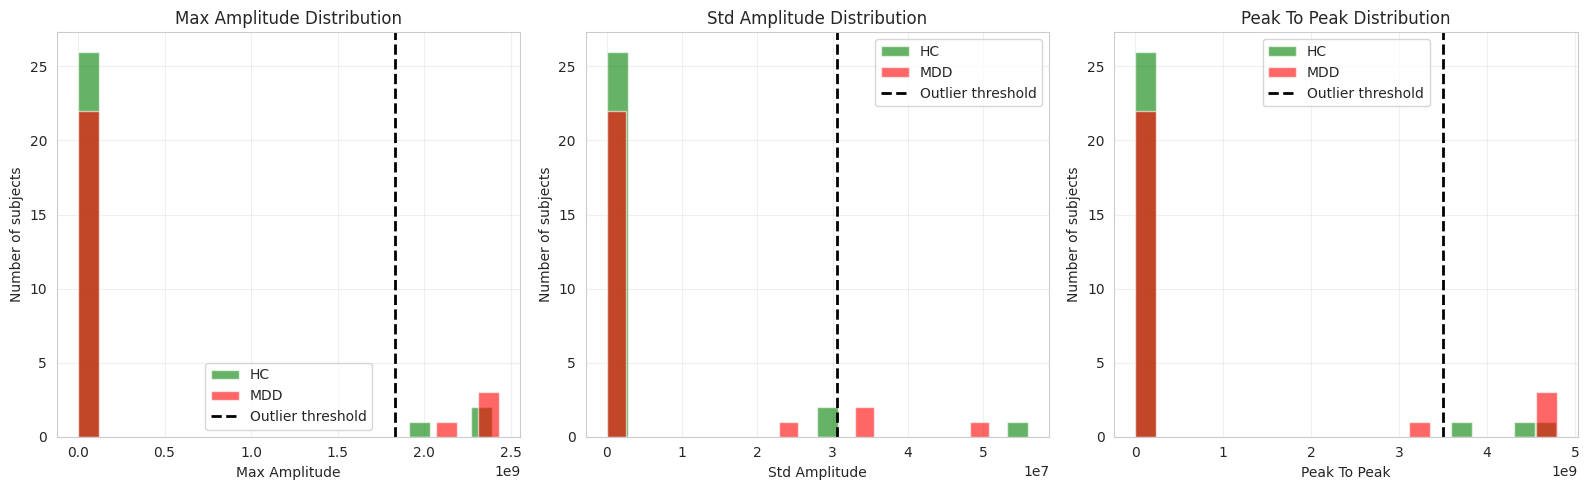


✅ Quality assessment complete!


In [28]:
# Quality Assessment - Statistical Outlier Detection

print("DATA QUALITY ASSESSMENT - STATISTICAL APPROACH")
print("=" * 70)

# Recalculate quality metrics with correct understanding of data scale
quality_metrics_list = []

for subject_id, filtered_raw in preprocessed_data.items():
    data = filtered_raw.get_data()
    
    metrics = {
        'subject_id': subject_id,
        'max_amplitude': np.abs(data).max(),
        'mean_amplitude': np.abs(data).mean(),
        'std_amplitude': data.std(),
        'peak_to_peak': data.max() - data.min()
    }
    
    quality_metrics_list.append(metrics)

# Convert to DataFrame
quality_df = pd.DataFrame(quality_metrics_list)

# Add metadata
quality_df['subject_id_num'] = quality_df['subject_id'].astype(float)
quality_df = quality_df.merge(
    metadata[['subject id', 'type']], 
    left_on='subject_id_num', 
    right_on='subject id', 
    how='left'
)

# Calculate outlier thresholds (mean + 2*SD)
metrics_to_check = ['max_amplitude', 'std_amplitude', 'peak_to_peak']

print("\nOutlier Detection Thresholds (Mean + 2*SD):")
print("-" * 70)

for metric in metrics_to_check:
    mean_val = quality_df[metric].mean()
    std_val = quality_df[metric].std()
    threshold = mean_val + 2 * std_val
    
    outliers = quality_df[quality_df[metric] > threshold]
    
    print(f"\n{metric}:")
    print(f"  Mean: {mean_val:.2f}")
    print(f"  SD: {std_val:.2f}")
    print(f"  Threshold (Mean + 2*SD): {threshold:.2f}")
    print(f"  Outliers detected: {len(outliers)}")
    
    if len(outliers) > 0:
        print(f"  Outlier subjects: {outliers['subject_id'].tolist()}")

# Flag any subject that's an outlier on ANY metric
quality_df['is_outlier'] = False
for metric in metrics_to_check:
    threshold = quality_df[metric].mean() + 2 * quality_df[metric].std()
    quality_df.loc[quality_df[metric] > threshold, 'is_outlier'] = True

print("\n" + "=" * 70)
print(f"\nFINAL QUALITY SUMMARY:")
print(f"Total subjects: {len(quality_df)}")
print(f"Clean subjects: {(~quality_df['is_outlier']).sum()}")
print(f"Outlier subjects: {quality_df['is_outlier'].sum()}")

if quality_df['is_outlier'].sum() > 0:
    print(f"\nOutlier breakdown by group:")
    print(quality_df.groupby('type')['is_outlier'].sum())

# Visualize the distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, metric in enumerate(metrics_to_check):
    ax = axes[i]
    
    # Plot distribution by group
    quality_df[quality_df['type']=='HC'][metric].hist(
        bins=20, alpha=0.6, label='HC', color='green', ax=ax
    )
    quality_df[quality_df['type']=='MDD'][metric].hist(
        bins=20, alpha=0.6, label='MDD', color='red', ax=ax
    )
    
    # Mark threshold
    threshold = quality_df[metric].mean() + 2 * quality_df[metric].std()
    ax.axvline(threshold, color='black', linestyle='--', linewidth=2, label='Outlier threshold')
    
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel('Number of subjects')
    ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Quality assessment complete!")

In [29]:
# Feature Extraction - All Subjects (Clean + Outliers)

from scipy.signal import welch

print("FEATURE EXTRACTION FROM PREPROCESSED EEG")
print("=" * 70)

# Define frequency bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30)
}

def extract_features(raw_object, subject_id):
    """
    Extract depression biomarker features from EEG data.
    
    Returns dictionary with all features.
    """
    # Get data for each channel
    data = raw_object.get_data()
    fp1_data = data[0, :]  # Left frontal
    fpz_data = data[1, :]  # Center
    fp2_data = data[2, :]  # Right frontal
    
    # Compute PSD for each channel
    freqs, psd_fp1 = welch(fp1_data, fs=250, nperseg=2048)
    freqs, psd_fpz = welch(fpz_data, fs=250, nperseg=2048)
    freqs, psd_fp2 = welch(fp2_data, fs=250, nperseg=2048)
    
    features = {'subject_id': subject_id}
    
    # Extract band powers for each channel
    for band_name, (low, high) in bands.items():
        mask = (freqs >= low) & (freqs <= high)
        
        # Power in each channel
        features[f'{band_name}_FP1'] = psd_fp1[mask].mean()
        features[f'{band_name}_FPZ'] = psd_fpz[mask].mean()
        features[f'{band_name}_FP2'] = psd_fp2[mask].mean()
        
        # Average power across all channels
        features[f'{band_name}_avg'] = (psd_fp1[mask].mean() + 
                                        psd_fpz[mask].mean() + 
                                        psd_fp2[mask].mean()) / 3
        
        # Peak frequency in this band
        features[f'{band_name}_peak_freq'] = freqs[mask][
            ((psd_fp1[mask] + psd_fpz[mask] + psd_fp2[mask]) / 3).argmax()
        ]
    
    # KEY FEATURE 1: Frontal Alpha Asymmetry (Right - Left)
    features['Alpha_Asymmetry'] = features['Alpha_FP2'] - features['Alpha_FP1']
    
    # KEY FEATURE 2: Theta/Beta Ratio (emotional regulation marker)
    features['Theta_Beta_Ratio'] = features['Theta_avg'] / features['Beta_avg']
    
    # KEY FEATURE 3: Alpha Peak Frequency
    alpha_mask = (freqs >= 8) & (freqs <= 13)
    alpha_psd_avg = (psd_fp1[alpha_mask] + psd_fpz[alpha_mask] + psd_fp2[alpha_mask]) / 3
    features['Alpha_Peak_Frequency'] = freqs[alpha_mask][alpha_psd_avg.argmax()]
    
    return features

# Extract features for all subjects
print("\nExtracting features from all 55 subjects...")
all_features = []

for subject_id, raw_object in preprocessed_data.items():
    features = extract_features(raw_object, subject_id)
    all_features.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)

# Merge with metadata and quality flags
features_df['subject_id_num'] = features_df['subject_id'].astype(float)
features_df = features_df.merge(
    metadata[['subject id', 'type', 'PHQ-9', 'GAD-7', 'age', 'gender']], 
    left_on='subject_id_num', 
    right_on='subject id', 
    how='left'
)

# Add quality flag
features_df = features_df.merge(
    quality_df[['subject_id', 'is_outlier']], 
    on='subject_id', 
    how='left'
)

print(f"✅ Feature extraction complete!")
print(f"\nExtracted {len(features_df.columns)} features from {len(features_df)} subjects")

# Create two datasets
clean_features = features_df[~features_df['is_outlier']].copy()
all_features_df = features_df.copy()

print(f"\nDataset split:")
print(f"  All subjects: {len(all_features_df)} (MDD: {len(all_features_df[all_features_df['type']=='MDD'])}, HC: {len(all_features_df[all_features_df['type']=='HC'])})")
print(f"  Clean only: {len(clean_features)} (MDD: {len(clean_features[clean_features['type']=='MDD'])}, HC: {len(clean_features[clean_features['type']=='HC'])})")

# Preview key features
print("\nKey Features Preview (first 5 subjects):")
print("=" * 70)
display(features_df[['subject_id', 'type', 'Alpha_Asymmetry', 'Theta_Beta_Ratio', 
                      'Alpha_Peak_Frequency', 'Alpha_avg', 'is_outlier']].head())

print("\n🎉 Ready for statistical analysis!")
print("\nNext steps tomorrow:")
print("1. Compare features between MDD vs HC (both datasets)")
print("2. Statistical tests and effect sizes")
print("3. Visualizations")
print("4. Machine learning classification")

FEATURE EXTRACTION FROM PREPROCESSED EEG

Extracting features from all 55 subjects...
✅ Feature extraction complete!

Extracted 32 features from 55 subjects

Dataset split:
  All subjects: 55 (MDD: 26, HC: 29)
  Clean only: 48 (MDD: 22, HC: 26)

Key Features Preview (first 5 subjects):


,subject_id,type,Alpha_Asymmetry,Theta_Beta_Ratio,Alpha_Peak_Frequency,Alpha_avg,is_outlier
0,2010001,MDD,-443.400113,8.680833,8.056641,25810.941576,False
1,2010002,MDD,760.537477,4.869565,10.375977,9750.147075,False
2,2010003,MDD,-21171.172453,11.495627,9.399414,29296.176262,False
3,2010005,MDD,3722.080920,8.208824,11.352539,9583.132181,False
4,2010006,MDD,693.826922,3.993295,10.253906,16302.916491,False



🎉 Ready for statistical analysis!

Next steps tomorrow:
1. Compare features between MDD vs HC (both datasets)
2. Statistical tests and effect sizes
3. Visualizations
4. Machine learning classification


## tomorrow plan
Statistical Comparison: Do MDD and HC differ on these features?
Effect Sizes: How big are the differences?
Visualizations: Show the group differences clearly
Machine Learning: Can we predict depression from brain features?
Compare results: Do findings hold with vs without outliers?

